In [1]:
import numpy as np
import pandas as pd
import xlrd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:

raw_data = pd.read_csv(r"data_clean_after_stopwords_first5K.csv", parse_dates=[0])

reindexed_data = raw_data['headline_cleaned_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()


,publish_date,headline_cleaned_text
0,2003-02-19,decides community broadcasting licence
1,2003-02-19,witness aware defamation
2,2003-02-19,call infrastructure protection summit
3,2003-02-19,staff aust strike rise
4,2003-02-19,strike affect australian traveller


In [3]:
raw_data.isnull().sum()

publish_date             0
headline_cleaned_text    5
dtype: int64

In [4]:
raw_data = pd.read_csv('data_clean_after_stopwords_first5K.csv')
reindexed_data = raw_data['headline_cleaned_text'].fillna('')

In [5]:
count_vectorizer = CountVectorizer(stop_words='english',max_features=200000)

document_term_matrix = count_vectorizer.fit_transform(reindexed_data)


In [6]:
n_topics = 8

In [7]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [8]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [9]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [10]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [11]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  govt urged defends considers local decision denies plan review opposition
Topic 2:  plan council development land vote merger resident water sought shire
Topic 3:  iraq bush troop howard saddam british blair weapon denies post
Topic 4:  council election seek land merger fund water considers rate urged
Topic 5:  court face charge murder drug trial appeal high child alleged
Topic 6:  claim reject title life victory abuse native telstra opposition iraqi
Topic 7:  world report death boost water group health concern sars open
Topic 8:  killed attack iraqi baghdad blast probe soldier bomb crash injured


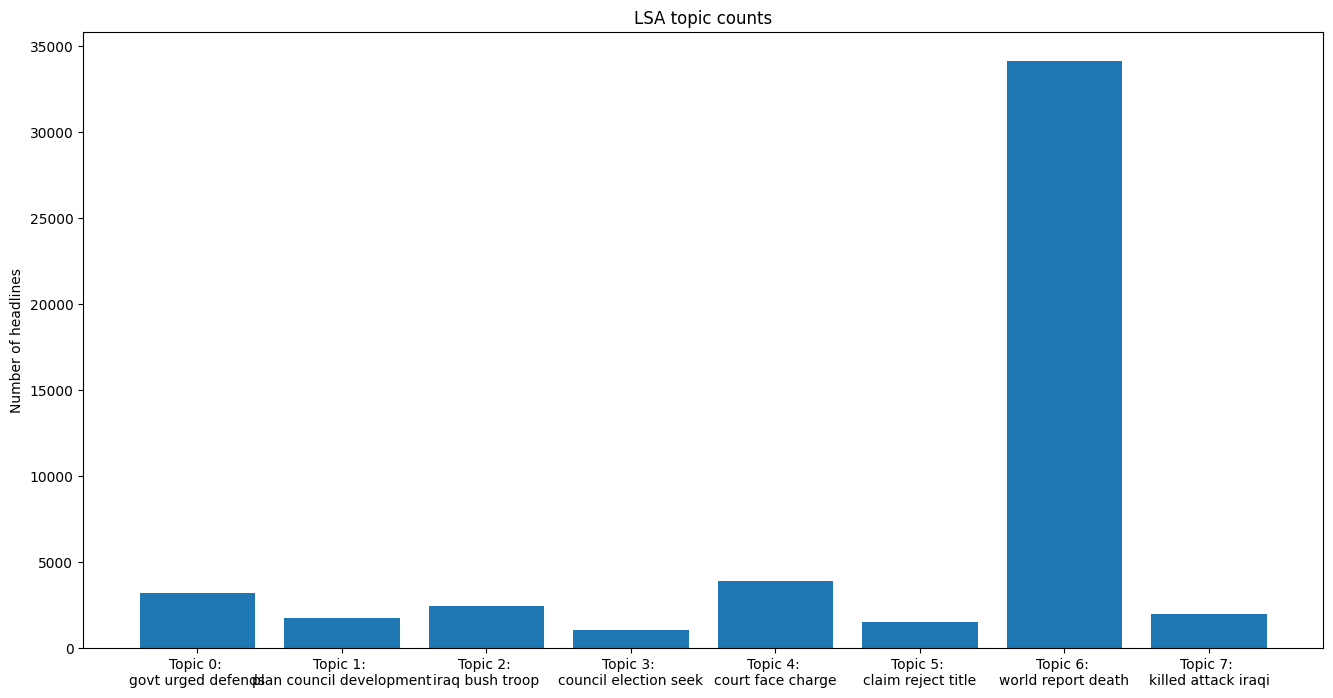

In [12]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [13]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.120s...
[t-SNE] Computed neighbors for 50000 samples in 7.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [14]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [15]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [16]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)